# Neural Collaborative Filtering

Collaborative filtering is traditionally done with matrix factorization. I did my movie recommendation project using good ol' matrix factorization. However, recently I discovered that people have proposed new ways to do collaborative filtering with deep learning techniques! There's a paper, titled [Neural Collaborative Filtering](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf), from 2017 which describes the approach to perform collaborative filtering using neural networks.

> In recent years, deep neural networks have yielded immense success on speech recognition, computer vision and 
> natural language processing. However, the exploration of deep neural networks on recommender systems has received 
> relatively less scrutiny. In this work, we strive to develop techniques based on neural networks to tackle the
> key problem in recommendation — collaborative filtering — on the basis of implicit feedback.

Here's the high level idea.

![ncf-high-level](./neural_collaborative_filtering_files/ncf-high-level.png)

## Embeddings

We perform embedding for each user and item(movie). The embedding layer is simply a matrix dot product of one hot encoding of a user/movie and the embedding weights. Let's put it concretely. Suppose I have ten users, the one hot encoding of each users will look like the following.

In [1]:
from keras.utils.np_utils import to_categorical

# We have 10 users, each is uniquely identified by an ID.
users = [i for i in range(10)]
to_categorical(users)

Using TensorFlow backend.


array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

Now I need an embedding weight matrix which will map a user or movie to an embedding vector. Let's define the embedding matrix to be a matrix of shape `(N, D)` where `N` is the number of users or movies and `D` is the latent dimension of embedding.

In [2]:
import numpy as np

latent_dim = 5
inputs = to_categorical(users)
embed_mat = np.random.randn(len(users), latent_dim)

inputs.dot(embed_mat)

array([[ 1.1391344 , -0.8752648 ,  1.25233597,  0.53437767, -0.18628979],
       [-0.66419168, -0.74328276, -0.01321763, -0.04430944, -1.44137598],
       [-2.07073338, -0.87598221, -1.49988311, -0.12476621, -0.34515032],
       [-0.75660572,  1.6298614 , -0.42899322,  0.24503306,  1.1110078 ],
       [ 0.75315852,  0.23002451,  0.36444158, -1.06237341,  0.8600944 ],
       [-0.4396186 , -0.87063947,  1.16428906, -1.13963026,  0.39431238],
       [ 0.25307581, -0.44974305, -0.30059679, -1.23073221,  2.35907361],
       [-0.47112505, -0.06720194,  1.46029474, -0.26472244, -0.1490059 ],
       [-0.58985416,  1.61182459,  0.41248058, -0.49178183, -0.24696098],
       [ 0.28085462,  0.21408553,  0.46972469, -0.03689734, -0.36638611]])

The embedded vectors will then be fed into a deep neural network and its objective is to predict the rating from a user given to a movie. For example, user 1 may rate movie 1 with five stars. The network should be able to predict that after training.

## Dataset: Movie Ratings

Before we dive into the details of the architecture, let's take a look at the datasets that we will be using for this exercise. I got the data from MovieLens. I will use the small dataset with 100,000 movie ratings.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('../datasets/100k/ratings.csv', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1 
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print 'Number of movies', num_movies
print 'Number of users', num_users

Number of movies 9066
Number of users 671


In [4]:
train.head()

,user_id,movie_id,rating,timestamp
70647,492,7625,4.0,898107789
29726,213,2029,4.0,1462639144
60508,439,956,3.0,1041115006
79013,547,4826,4.0,1022676793
65442,466,2176,2.0,945836678


In [5]:
test.head()

,user_id,movie_id,rating,timestamp
78939,547,1966,4.5,1093832403
28074,205,3576,4.0,1442152429
27716,201,178,5.0,1110498354
20913,144,76,3.0,837455700
58482,425,416,0.5,1112537722


## Generalized Matrix Factorization (GMF)

In the context of the paper, a generalized matrix factorization can be described by the following equation.

$$
\hat{y}_{ui} = a\left(h^{T}(p_{u} \cdot q_{i})\right)
$$

where $a$ is an activation function and $h$ is the edge weight matrix of the output layer. The edge weight matrix can be seen as an additional weight to the layer. 

### Matrix Factorization
If we use an identity function for activation and enforce the edge weight matrix to be a uniform vector of 1, we can exactly recover the standard matrix factorization model.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


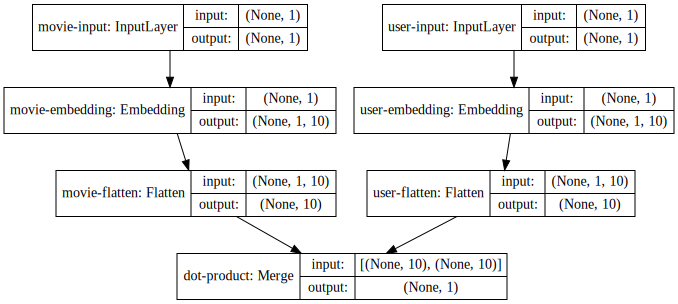

In [6]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge
from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

# Let's use a higher latent dimension.
latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = merge([movie_vec, user_vec], mode='dot',name='dot-product')

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In the model above, we are not using any activation function and there is no additional weight to layer. The model above represents a classic matrix factorization. It takes two inputs, a user ID and a movie ID. The inputs are embedded into `(1, 5)` vectors. The vectors are then flattened. The dot product of the flattened vectors is the predicted rating.

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
movie-input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
user-input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
movie-embedding (Embedding)      (None, 1, 10)         90670       movie-input[0][0]                
____________________________________________________________________________________________________
user-embedding (Embedding)       (None, 1, 10)         6720        user-input[0][0]                 
___________________________________________________________________________________________

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, nb_epoch=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

Epoch 1/10
80003/80003 [==============================] - 3s - loss: 11.3523     
Epoch 2/10
80003/80003 [==============================] - 3s - loss: 3.7727     
Epoch 3/10
80003/80003 [==============================] - 3s - loss: 1.9556     
Epoch 4/10
80003/80003 [==============================] - 3s - loss: 1.3729     
Epoch 5/10
80003/80003 [==============================] - 3s - loss: 1.1114     
Epoch 6/10
80003/80003 [==============================] - 3s - loss: 0.9701     
Epoch 7/10
80003/80003 [==============================] - 3s - loss: 0.8845     
Epoch 8/10
80003/80003 [==============================] - 3s - loss: 0.8266     
Epoch 9/10
80003/80003 [==============================] - 2s - loss: 0.7858     
Epoch 10/10
80003/80003 [==============================] - 3s - loss: 0.7537     


<Figure size 640x480 with 1 Axes>

0.7882400871806331

We can go a little further by making it a non-negative matrix factorization by adding a `non-negativity` constraints on embeddings. 

```python
from keras.constraints import non_neg

latent_dim = 5

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding', 
                                                        embeddings_constraint=non_neg())(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding', 
                                                      embeddings_constraint=non_neg())(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = merge([movie_vec, user_vec], mode='dot',name='dot-product')

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')
```

### Neural Network with MF

Now let's add some non-linearities to make it non-linear matrix factorization, which is essentially appending a neural network to the end of the model.

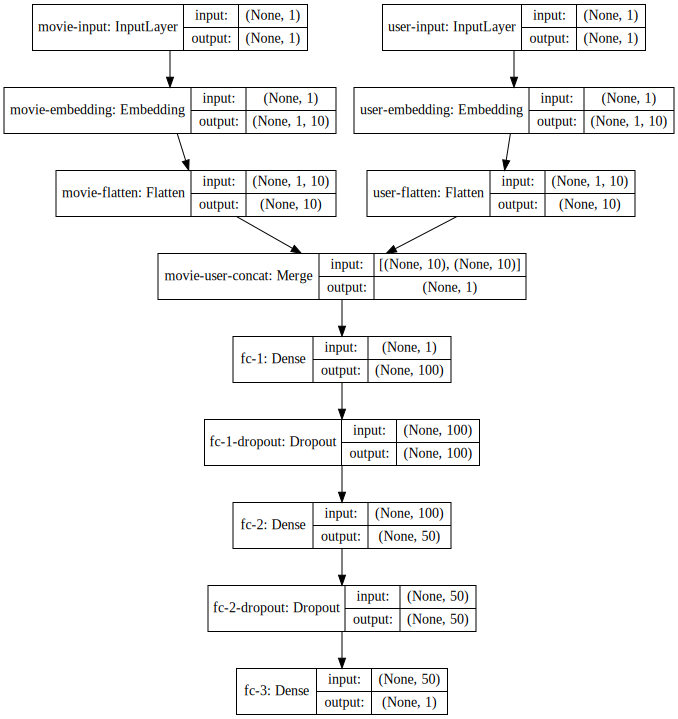

In [14]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, Dropout, Dense
from keras.optimizers import Adam
from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = merge([movie_vec, user_vec], mode='dot',name='movie-user-concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)


model = Model([user_input, movie_input], fc_3)
model.compile(optimizer=Adam(lr=0.1), 'mean_squared_error')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
movie-input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
user-input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
movie-embedding (Embedding)      (None, 1, 10)         90670       movie-input[0][0]                
____________________________________________________________________________________________________
user-embedding (Embedding)       (None, 1, 10)         6720        user-input[0][0]                 
___________________________________________________________________________________________

Epoch 1/10
80003/80003 [==============================] - 4s - loss: 1.4558     
Epoch 2/10
80003/80003 [==============================] - 4s - loss: 0.8774     
Epoch 3/10
80003/80003 [==============================] - 4s - loss: 0.6612     
Epoch 4/10
80003/80003 [==============================] - 4s - loss: 0.5588     
Epoch 5/10
80003/80003 [==============================] - 4s - loss: 0.4932     
Epoch 6/10
80003/80003 [==============================] - 4s - loss: 0.4513     
Epoch 7/10
80003/80003 [==============================] - 4s - loss: 0.4212     
Epoch 8/10
80003/80003 [==============================] - 4s - loss: 0.3973     
Epoch 9/10
80003/80003 [==============================] - 4s - loss: 0.3796     
Epoch 10/10
80003/80003 [==============================] - 4s - loss: 0.3647     


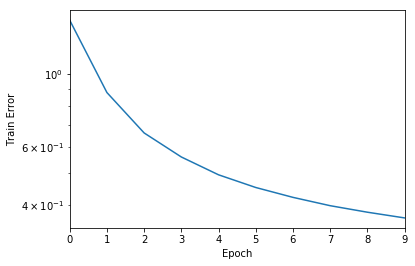

0.76091345600364002

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, nb_epoch=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

## Multi-Layer Perceptron

The paper proposes a slightly different architecture than the one I showed above. Previously, we have already covered what is a **generalized matrix factorization** model. It's just a framing the original matrix factorization technique in a neural network architecture. Now we take a step even further to create two pathways to model users and items interactions. The multi-layer perceptron is essentially a deep neural network similar to what is shown above, except now we will take it out and put it into a separate path way instead of appending it to the end of the vanilla matrix factorization.

Here's a straightforward approach, quoted directly from the paper.

> Let GMF and MLP share the same embedding layer and then combine the outputs of their interactive functions.
> This way shares a similar spirit with the well-known Neural Tensor Network (NTN). Specifically, the model for
> combining GMF with a one-layer MLP can be forumated as.

$$
\hat{y}_{ui} = \sigma\left(h^{T}a\left(p_{u} \cdot q_{u} + W\begin{bmatrix}p_{u}\\q_{u}\end{bmatrix}+b\right)\right)
$$

However, the authors believed that sharing the embeddings of GMF and MLP might limit the performance of fused model. They want to provide more flexibility to the model and allow GMF and MLP to learn separate embeddings. They will combine the two models by concatenating the last hidden layer.

![ncf-architecture](./neural_collaborative_filtering_files/ncf-architecture.png)

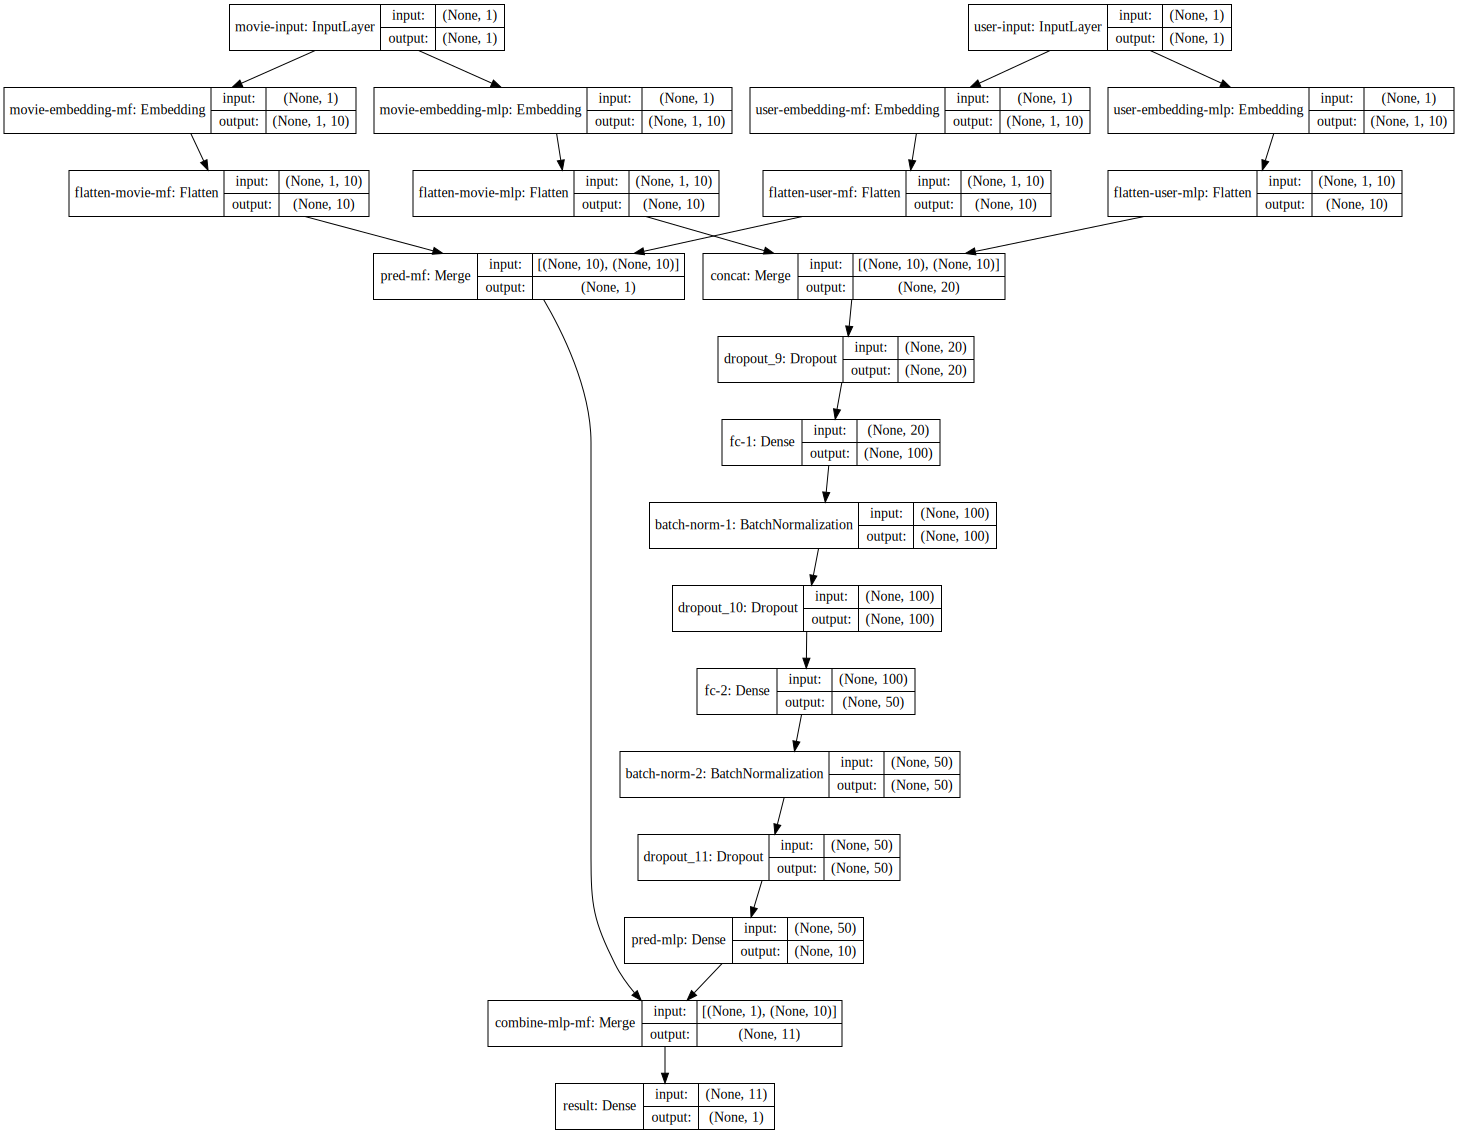

In [9]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

latent_dim = 10

# Define inputs
movie_input = Input(shape=[1],name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = merge([movie_vec_mlp, user_vec_mlp], mode='concat', name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn) 
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = merge([movie_vec_mf, user_vec_mf], mode='dot', name='pred-mf')
combine_mlp_mf = merge([pred_mf, pred_mlp], mode='concat', name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(lr=0.01), loss='mean_absolute_error')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
movie-input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
user-input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
movie-embedding-mlp (Embedding)  (None, 1, 10)         90670       movie-input[0][0]                
____________________________________________________________________________________________________
user-embedding-mlp (Embedding)   (None, 1, 10)         6720        user-input[0][0]                 
___________________________________________________________________________________________

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, nb_epoch=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

Epoch 1/10
80003/80003 [==============================] - 6s - loss: 0.7955     
Epoch 2/10
80003/80003 [==============================] - 6s - loss: 0.6993     
Epoch 3/10
80003/80003 [==============================] - 6s - loss: 0.6712     
Epoch 4/10
80003/80003 [==============================] - 6s - loss: 0.6131     
Epoch 5/10
80003/80003 [==============================] - 6s - loss: 0.5646     
Epoch 6/10
80003/80003 [==============================] - 6s - loss: 0.5291     
Epoch 7/10
80003/80003 [==============================] - 6s - loss: 0.5070     
Epoch 8/10
80003/80003 [==============================] - 6s - loss: 0.4896     
Epoch 9/10
80003/80003 [==============================] - 6s - loss: 0.4744     
Epoch 10/10
80003/80003 [==============================] - 6s - loss: 0.4630     


<Figure size 640x480 with 1 Axes>

0.7199715004626599